# Quantum Feedback Delay Networks
## Davide Rocchesso 
## University of Palermo
Updated for [qiskit > 1.0](https://www.ibm.com/quantum/qiskit) by [Cumhur Erkut](https://cerkut.github.io) on 2025-03-23.

Please do at the root of the repo either

```bash
pip install .
```

or better, if you use [uv](https://docs.astral.sh/uv)
```bash
uv sync
```


In [108]:
# Boolean switches for optional actions
save_figure = False
play_sound = True
save_sound = False

In [109]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, Operator
from qiskit_aer import Aer

In [110]:
from qiskit.transpiler.passes import Decompose
from qiskit.quantum_info import entanglement_of_formation # measure how entangled is 
                                                          # a state (in Bell states)

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd

import sys, os
# these scripts require the Spectral Modeling Synthesis Tools (https://www.upf.edu/web/mtg/sms-tools)
# models and transformations have been copied in this same directory
sys.path.append(os.path.join(os.path.realpath("."), './models/'))
sys.path.append(os.path.join(os.path.realpath("."), './transformations/'))
import hpsModel as HPS
import hpsTransformations as HPST
import harmonicTransformations as HT
import utilFunctions as UF
import stft as STFT
from IPython.display import IFrame

### Classic delay lines
Delay lines are implemented as a circular buffer just as long as its corresponding delay lines, so that the single sample is first read (```get```) at ```cur``` position and then overwritten (```put```).

In [112]:
class CircularBuffer:
    """ class that implements a circular buffer """
    def __init__(self,size_max,init_value):
        self.max = size_max
        self.data = np.zeros(self.max, dtype = 'complex_') + init_value 
        self.cur = 0
    def put(self, x):
        """ write an element overwriting the oldest one. """
        self.data[self.cur] = x
        self.cur = (self.cur+1) % self.max
    def get(self):
        """ return element at cur """
        return self.data[self.cur]


In [113]:
# sample usage
x=CircularBuffer(5,0)
x.put(1); x.put(2); x.put(3); x.put(4)
print(x.data)
print("---")
x.put(5)
x.put(6)
print(x.data)
print("read at ", x.cur, ": ", x.get())
x.put(7); 
print("read at ", x.cur, ": ", x.get())
print(x.data)



[1.+0.j 2.+0.j 3.+0.j 4.+0.j 0.+0.j]
---
[6.+0.j 2.+0.j 3.+0.j 4.+0.j 5.+0.j]
read at  1 :  (2+0j)
read at  2 :  (3+0j)
[6.+0.j 7.+0.j 3.+0.j 4.+0.j 5.+0.j]


### The recursive Quantum Comb Filter
A (feedback) comb filter is a basic ingredient for fundamental sound synthesis (Karplus-Strong) and artificial reverberation (Schroeder, Moorer). Essentially, the comb filter is a feedback loop containing a delay line, a multiply/filter for in-loop attenuation, and an adder for input signal.

Can we extend a similar structure to digital audio encoded as qubits? 

#### One delay
Qubits are not easily delayed nor managed in circular buffers. However, in a simulation environment, we can think of knowing and delaying one of the two probability amplitudes defining the state of a qubit, knowing that the other must be power-complementary. Actually, there are infinitely many possibilities for power-complementary probability amplitude, but we may choose the one that is real and positive.

<img src="Qcomb1.png" width="600">

*amplitude encoding*: instantaneous input, with scaling and amplitude to stay between 0 and 1, as first amplitude probability. This is essentially quantum probability amplitude modulation (QPAM [[Itaborai and Miranda, 2022](https://link.springer.com/chapter/10.1007/978-3-031-13909-3_10)]). In general, the first probability amplitude of a multi-qubit quantum state can be set to the scaled and shifted signal value, and the other probability amplitudes (only one in the case of a qubit) can be set to the same value, such that the sum of the squares of all amplitude magnitudes gives one. The zero signal value is set at probability-amplitude value $\sqrt{0.5}$, and the minus-one signal is set to $0$. If we consider a state $\left[1, 0\right]'$, corresponding to signal value one, and evolve it through a Hadamard gate, we get the state $\left[1/\sqrt{2}, 1/\sqrt{2} \right]'$, that would correspond to a zero signal value. Similarly, the state $\left[0, 1\right]'$ would be Hadamard-evolved to $\left[1/\sqrt{2}, -1/\sqrt{2} \right]'$, that would be another form of zero signal. 

*delay initialization*: delays carry probability amplitudes. We initialize them in such a way that a identity feedback matrix would produce a constant output identical to the zero input. This requires initializing the delays with $1/\sqrt{2}$.

*summation nodes*: having a probability-encoding of the input that produces a legitimate state vector $|\psi> = \left[\sqrt{input}, \sqrt{1 - input} \right]' = a_0 |0> + b_0 |1> $, we can sum it to the state that results for matrix-evolution of $|sOut>$, that is $|\phi> = a_1 |0> + b_1 |1> $, as 
$$
|\psi> + |\phi> = \sqrt{\frac{{|a_0|}^2 + {|a_1|}^2}{2}} |0> + \sqrt{\frac{{|b_0|}^2 + {|b_1|}^2}{2}} |1> 
$$ 
This operation forces the probability amplitudes at the entrance of delay lines to be real valued and positive.

*Identity matrix*: constant zero (i.e., 0.5) input produces constant zero output. A unit impulse in the input produces a decaying impulse train, with amplitudes $0.75, 0.625, 0.5625, 0.53125$. Subtracting the $0.5$ offset we get a perfect division by two at every cycle, as in a comb with loop coefficient set at 0.5. The response to a damped sinusoid is a distorted and
delay-modulated damped sinusoid

<img src="comb1qubitDampedOsc.png" width="600">

*Hadamard matrix*: constant zero input, with delay initialized at $1/\sqrt{2}$, generates a staircase Gibbs oscillation with peak at 0.75, and converging to 0.7236. <!---The asymptote must be related with the eigenvectors of the Hadamard matrix, namely with $\left[0.9239, 0.3827 \right]'$.---> A unit impulse in the input produces decaying impulses alternating their signs around the staircase oscillation. The response to a damped sinusoid is a distorted and delay-modulated damped sinusoid.

<img src="comb1qubitHzero.png" width="600">

<img src="comb1qubitHone.png" width="600">

<img src="comb1qubitHDampedOsc.png" width="600">

The Hadamard matrix is equivalent to a rotation by $-\pi/2$ around the y axis, followed by a phase flip (Z gate). With rotations between 0 and $-\pi/2$ about the y axis, we can get behaviors that are intermediate between identity and Hadamard. For example, for a rotation of $\pi/16$:

<img src="comb1qubitHDampedOscRotPi16.png" width="600">


In [ ]:
# Quantum Comb Filter
# Matrix = [[1/np.sqrt(2), 1/np.sqrt(2)], # Hadamard gate as a feedback matrix
#          [1/np.sqrt(2), -1/np.sqrt(2)]] 
Matrix = [[1, 0], [0, 1]] # identity matrix
Matrix = np.array(Matrix, dtype = 'complex_')
Combgate = UnitaryGate(Matrix)
Comb = QuantumCircuit(1,1) 
phase0 = -np.pi/(1.999999999*8)  # # dividing by 2.0 there may be a glitch stepping in
fCoef = 1.0
# Comb.rz(phase0, 0)  # z-rotation of qubit 0
# Comb.ry(phase0, 0); Comb.z(0);  # y-rotation and phase-flip of qubit 0
Comb.append(Combgate, [0])
m0 = 59
initDelay = np.sqrt(0.5) 
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m0, initDelay)]
stateIn = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5) ## 0.5
stateOut = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5)
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 0.99999; # impulse
# input = (0.5 + 0.5*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
#                 np.exp(-np.arange(timeSpan)/200*5)) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = (x/2 + 0.5); 
plt.plot(input,'-.')
plt.ylim([0.0, 1])
plt.xlim([0, 400])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = delay[0].get()                       # delays output probability
    stateOut[0] = aq * fCoef         # compute amplitudes (try with changing signs)
    stateOut[1] = np.sqrt(1 - np.abs(stateOut[0])**2)
    # input of delay is  first probability amplitude
    delay[0].put(stateIn[0])
    sOut = Statevector(stateOut)
    # print(sOut)
    output[n] = sOut.probabilities([0])[0]  # probability of qubit 0 being up 
    sOut = sOut.evolve(Comb)
    stateOut = sOut.data
    sIn = Statevector([np.sqrt(np.abs(input[n])), np.sqrt(1 - np.abs(input[n]))])
    # print("sIn[0] = ", sIn[0], "stateOut[0] = ", stateOut[0])
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(stateOut[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(stateOut[1])**2)/2)
    if not Statevector(stateIn).is_valid(): 
        print("Invalid")
plt.plot(output)
if save_figure:    
    plt.savefig('comb1qubitHDampedOsc.pdf')
if play_sound:
    sd.play(output-1/2, fs)
if save_sound:
    UF.wavwrite(output-1/2, fs, "comb1qubitHdampedOsc.wav")

SyntaxError: invalid syntax (2973977363.py, line 51)

#### Two delays
Alternatively, we can delay both probability amplitudes, even with different delay lines. This is not physically consistent, because we can not decompose a qubit into two halves, each with its own evolution. Moreover, we must make sure that the output of the delay line pair is always a consistent quantum state, through amplitude normalization.

<img src="Qcomb2.png" width="600">

If the delays are set equal in length, the behavior is physically feasible and corresponds to delaying the incoming qubit. In this case the circuit is almost equivalent to that of the single delay, with the difference that the state phase (and sign) can be maintained through the loop. Essentially, the input mixes in-phase with the feedback loop.

If the delays are different, we get a different and more articulated response.

**Equal delays**
*Identity matrix*: constant zero (i.e., 0.5) input produces constant zero output. A unit impulse in the input produces a decaying impulse train, with amplitudes $0.75, 0.625, 0.5625, 0.53125$. Subtracting the $0.5$ offset we get a perfect division by two at every cycle, as in a comb with loop coefficient set at 0.5. The response to a damped sinusoid is a distorted and delay-modulated damped sinusoid

<img src="comb1qubitDampedOsc.png" width="600">

*Hadamard matrix*: constant zero input, with delay initialized at $1/\sqrt{2}$, generates a staircase Gibbs oscillation with peak at 0.75, and converging to 0.7236. <!---The asymptote must be related with the eigenvectors of the Hadamard matrix, namely with $\left[0.9239, 0.3827 \right]'$.---> A unit impulse in the input produces initial decaying impulses alternating their signs around the staircase oscillation and, from the fourth period, a "negative" impulse at twice the delay period. The response to a damped sinusoid is a distorted and delay-modulated damped sinusoid.

<img src="comb1qubitHzero.png" width="600">

<img src="comb1qubitHone2.png" width="600">

<img src="comb1qubitHDampedOsc2.png" width="600">

The Hadamard matrix is equivalent to a rotation by −𝜋/2 around the y axis, followed by a phase flip (Z gate). With rotations between 0 and −𝜋/2 about the y axis, we can get behaviors that are intermediate between identity and Hadamard. For example, for a rotation of 𝜋/16, it converges toward a square wave, whose amplitude gets smaller for smaller rotations:

<img src="comb1qubitHDampedOscRotPi82.png" width="600">

When excited by a vocal trill, the latter configuration gives a modified trill, with the square wave that tends to take over during silences:

<img src="comb1qubitHbrrRotPi82.png" width="600">

<img src="track82ex02.png" width="300"><img src="comb1qubit2DelaysHbrr.png" width="300">


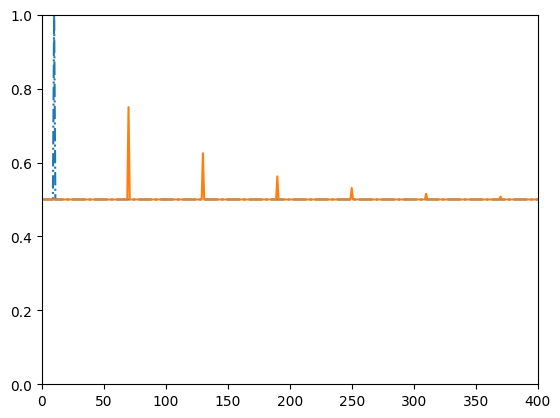

In [ ]:
# Quantum Comb Filter
np.set_printoptions(precision=20)
# Matrix = [[1/np.sqrt(2), 1/np.sqrt(2)], # Hadamard gate as a feedback matrix
#            [1/np.sqrt(2), -1/np.sqrt(2)]] 
Matrix = [[1, 0], [0, 1]] # identity matrix
Matrix = np.array(Matrix, dtype = 'complex_')
Combgate = UnitaryGate(Matrix)
Comb = QuantumCircuit(1,1) 
# phase0 = -np.pi/1.999999999 # dividing by 2.0 there is a glitch stepping in
phase0 = -np.pi/(1.999999999*8) 
fCoef = 1.0
# Comb.rz(phase0, 0)  # z-rotation of qubit 0
# Comb.ry(phase0, 0); Comb.z(0);   # y-rotation and phase-flip of qubit 0
Comb.append(Combgate, [0])
# print(Operator(Comb).data)
m0 = 59
m1 = 59
initDelays = np.sqrt(0.5)
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m0, initDelays), CircularBuffer(m1, np.sqrt(1 - initDelays**2))]
stateIn = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5) # 0.5
stateOut = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5)
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 0.99999; # impulse
# input = 0.5+0.49999*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
#              np.exp(-np.arange(timeSpan)/200*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.0, 1])
plt.xlim([0, 400])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    ssq = np.sqrt(np.abs(delay[0].get()*fCoef)**2 + np.abs(delay[1].get())**2) # normalize
    ssq = 1 if m0==m1 else ssq # normalization is not necessary if delays are equal
    stateOut[0] = delay[0].get()*fCoef/ssq        
    stateOut[1] = delay[1].get()/ssq  
    delay[0].put(stateIn[0]) # input of delay is  first probability amplitude
    delay[1].put(stateIn[1]) # input of delay is  second probability amplitude
    sOut = Statevector(stateOut) 
    output[n] = sOut.probabilities([0])[0] # probability of qubit 0 being up    
    sOut = sOut.evolve(Comb)
    stateOut = sOut.data
    sIn = Statevector([np.sqrt(np.abs(input[n])), np.sqrt(1 - np.abs(input[n]))
                      ])
    # sum the probability amplitudes of the encoded input with those 
    # of the matrix-evolved state: 
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(stateOut[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(stateOut[1])**2)/2)
    # if np.abs(np.angle(stateOut[0])) > 0.0000000001: # to avoid a numerical artifact (periodic spike)
    stateIn[0] = stateIn[0]*np.exp(1j*np.angle(stateOut[0]))  # keep the angle of the evolved state
    # if np.abs(np.angle(stateOut[1])) > 3.14:                                                   
    stateIn[1] = stateIn[1]*np.exp(1j*np.angle(stateOut[1]))
    if not Statevector(stateIn).is_valid(): 
        print("Invalid")
plt.plot(output)
if play_sound:    
    sd.play(output - 1 / 2, fs)
if save_figure:
    plt.savefig('comb1qubitHbrrRotPi82.pdf')
if save_sound:
    UF.wavwrite(output - 1 / 2, fs, "comb1qubitHbrrRotPi82.wav")
# Note: as soon as the output gets lower than 0.5 we get a negative spike that repeats at twice the delay length

*Input as a second qubit*: Instead of summing the probability amplitudes of the encoded input with those of the matrix-evolved state, we can effectively treat the input as a second qubit, and extend the Comb circuit to handle two qubits, one for feedback and one for input. The two qubits get entangled. We evolve such a couple of qubits and trace out the second qubit to feed the delay lines. 

*Identity matrix* With impulse as input, we get a delayed impulse. With damped sine as input, we get an occasionally distorted and delayed damped sine. If, before tracing out, we measure qubit 1, we introduce random glitches, and by y-rotation and phase flipping on qubit 0, the density of glitches can be controlled (Geiger counter effect).


[//]: # (*It was like this: Oscillatory damped excitation and rotation about y*: By changing the rotation angle we can change the attenuation time of the oscillatory output, that is distorted as compared to the input. For example, with rotation of $- \pi / 5$ around the y axis, and phase-flip, we get:  )

<!img src="comb1qubit2DelaysEnt.png" width="600">

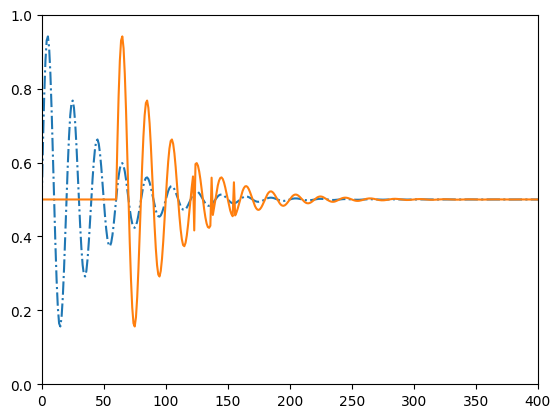

In [ ]:
# Quantum Comb Filter
# Matrix = [[1/np.sqrt(2), 1/np.sqrt(2)], # Hadamard gate as a feedback matrix
#           [1/np.sqrt(2), -1/np.sqrt(2)]] 
Matrix = [[1, 0], [0, 1]] # identity matrix
Matrix = np.array(Matrix, dtype = 'complex_')
Combgate = UnitaryGate(Matrix)
Comb = QuantumCircuit(2,1) 
# phase0 = -np.pi/1.999999999 # dividing by 2.0 there is a glitch stepping in
phase0 = -np.pi/1.999999999*8
fCoef = 1.0
# Comb.rz(phase0, 0)  # z-rotation of qubit 0
# Comb.ry(phase0, 0); Comb.z(0);   # y-rotation and phase-flip of qubit 0
Comb.append(Combgate, [0])
Comb.h(1)       # to entangle input and feedback
Comb.cx(1,0)    # (inverting 1 and 0 we switch from oscillatory to nothing) 
# Comb.x(1)     # these two additional instructions mix the state (see 1-min qiskit: initialize mixed states)
# Comb.ch(1,0)  # and we get an interesting behavior
m0 = 59
m1 = 59
initDelays = np.sqrt(0.5)
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m0, initDelays), CircularBuffer(m1, np.sqrt(1 - initDelays**2))]
stateIn = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5) # 0.5
stateOut = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5)
inputFile = './track82ex02.wav'
# input = np.zeros(timeSpan) + 0.5; input[10] = 0.99999; # impulse
input = 0.5+0.5*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
             np.exp(-np.arange(timeSpan)/200*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; plt.plot(input)
plt.plot(input, '-.')
plt.ylim([0.0, 1])
plt.xlim([0, 400])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    ssq = np.sqrt(np.abs(delay[0].get()*fCoef)**2 + np.abs(delay[1].get())**2) # normalize
    ssq = 1 if m0==m1 else ssq # normalization is not necessary if delays are equal
    stateOut[0] = delay[0].get()*fCoef/ssq        
    stateOut[1] = delay[1].get()/ssq  
    delay[0].put(stateIn[0])
    delay[1].put(stateIn[1])
    sOut = Statevector(stateOut)    
    output[n] = sOut.probabilities([0])[0] # probability of qubit 0 being up    
    sIn = Statevector([np.sqrt(np.abs(input[n])), np.sqrt(1 - np.abs(input[n]))
                      ])
    sOutIn = sOut.tensor(sIn) # extend the state to include the qubit encoding the input
    sOutIn = sOutIn.evolve(Comb)
    (outcome,sOutIn) = sOutIn.measure([1]) # if I measure it is cool!
    partial_density_matrix = partial_trace(sOutIn, [1]) # trace out the extra qubit
    stateIn = np.diagonal(partial_density_matrix) 
    stateIn = np.sqrt(stateIn) # purify the state
    # stateIn = stateIn / np.sqrt(np.sum(np.square(stateIn))) # it was like this, distorting
    if not Statevector(stateIn).is_valid(): 
        print("Invalid")
plt.plot(output)    
Comb.draw()
if play_sound:
    sd.play(output - 1 / 2, fs)
if save_figure: 
    plt.savefig('comb1qubit2DelaysEnt.pdf')
if save_sound:
    UF.wavwrite(output-1/2, fs, "comb1qubit2DelaysEnt.wav")


### Minimal QFDN in state space form
One qubit delayed by two equal-length (2 samples) delay lines. Excluding input and output, the feedback delay loop corresponds to repeated evolution of a two-qubit quantum state, which is specified by the four probability amplitudes stored in each of the ($2 \times 2$)  delay units.

<img src="Qcomb2ss.png" width="600">

The system state is $$|w> = \left[ p_1, p_2, s_1, s_2 \right]' $$ 
and the state-evolution matrix is 
$$ \underline{A} = \begin{bmatrix}
0 & 0 & a_{1,1} & a_{1,2} \\
0 & 0 & a_{2,1} & a_{2,2} \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix} 	
$$

The two-qubit quantum state can be initialized to perfect superposition, with all probability amplitudes set to $1/\sqrt{4} = 1/2$, which is different from the previous case where the evolution is on a single qubit at a time. 

To extract an output in QPAM according to the figure, we extract the probability of the third element of vector $|w>$, corresponding to number $s_1$, or probability of qubits being in state $[1, 0]$.

A tensor product is formed between the state and the input, which is evolved by a 3-qubit circuit. Then one of the qubits is traced-out and a new state is formed. In this way, either the matrix or the input turn out to be irrelevant. However, if we entangle (input) qubit 2 with qubit 0, and we measure qubit 2 before letting the two other qubits evolve, we get an interesting effect: with y-rotation and phase-flip we get a sort of micro-reverberation, with stochastic spikes having increasing amplitude for decreasing value of the rotation phase.

[//]: # (I previously experimented with: Here, after evolution by matrix multiplication, the four-numbers state is reduced to two numbers by partial trace, and such one-qubit state is extended again to two qubits - four numbers - by tensor product with the input.)

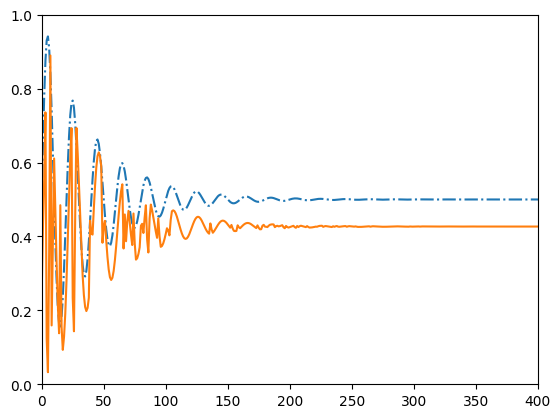

In [ ]:
# Feedback Delay Network
Matrix = [[0, 0, 1/np.sqrt(2), 1/np.sqrt(2)],
          [0, 0, 1/np.sqrt(2), -1/np.sqrt(2)],
          [1, 0, 0, 0],
          [0, 1, 0, 0]]
Matrix = [[0, 0, 1, 0],
          [0, 0, 0, 1],
          [1, 0, 0, 0],
          [0, 1, 0, 0]]
Matrix = np.array(Matrix, dtype = 'complex_')
FDNgate = UnitaryGate(Matrix)

Combgate = UnitaryGate(Matrix)
Comb = QuantumCircuit(3,1) 
# phase0 = -np.pi/1.999999999 
phase0 = -np.pi/1.999999999*8.5 # varying distortion and amplitude of output with y-rotation and phase-flip
Coef = 1.0
# Comb.rz(phase0, 1)  # z-rotation of qubit 0
Comb.ry(phase0, 1); Comb.z(1);   # y-rotation and phase-flip of qubit 1
Comb.append(Combgate, [0, 1])
Comb.h(2)       # to entangle input and feedback
Comb.cx(2,0)    # (inverting 2 and 0 we switch from oscillatory to transient) 
# Comb.measure([2],[0])
timeSpan = 3200
fs = 8000
stateIn = np.zeros(2, dtype = 'complex_') + np.sqrt(0.5) 
sOutIn = Statevector(np.zeros(4, dtype = 'complex_') + np.sqrt(0.25) )
inputFile = './track82ex02.wav'
# input = np.zeros(timeSpan) + 0.5; input[10] = 1.0; # impulse
input = 0.5+0.5*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
               np.exp(-np.arange(timeSpan)/200*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.0, 1])
plt.xlim([0, 400])
output = np.zeros(timeSpan)
for n in range(timeSpan): 
    output[n] = Statevector(sOutIn).probabilities()[2] # probability of measuring [1,0] 
    sIn = Statevector([np.sqrt(np.abs(input[n])), np.sqrt(1 - np.abs(input[n]))])
    sOutIn = Statevector(sOutIn).tensor(sIn)
    sOutIn = sOutIn.evolve(Comb)
    (outcome,sOutIn) = sOutIn.measure([2]) # if I measure it is cool!
    partial_density_matrix = partial_trace(sOutIn, [2]) # trace out the extra qubit
    # Ops without measurement! If traceout 2 -> no effect of matrix; if traceout 0 -> no effect of input
    sOutIn = np.diagonal(partial_density_matrix) 
    sOutIn = np.sqrt(sOutIn) # purify the state
    # sOutIn = sOutIn / np.sqrt(np.sum(np.square(sOutIn))) # it was like this, distorting
    if not Statevector(sOutIn).is_valid(): 
        print("Invalid")    
plt.plot(output)
Comb.draw()
# make conditional 
if play_sound:
    sd.play(output-1/np.sqrt(2), fs)
if save_figure:
    plt.savefig('threeQubits2DelaysEnt.pdf')
    Comb.draw(initial_state=False,output='latex').save('twoQubitsOneInput.pdf')

Here we directly sum-normalize the input, all numbers positive real

In [ ]:
# Feedback Delay Network
Matrix = [[0, 0, 1/np.sqrt(2), 1/np.sqrt(2)],
          [0, 0, 1/np.sqrt(2), -1/np.sqrt(2)],
          [1, 0, 0, 0],
          [0, 1, 0, 0]]
Matrix = [[0, 0, 1, 0],
          [0, 0, 0, 1],
          [1, 0, 0, 0],
          [0, 1, 0, 0]]
Matrix = np.array(Matrix, dtype = 'complex_')
Combgate = UnitaryGate(Matrix)
FDNgate = UnitaryGate(Matrix, label="FDNgate")
circuit = QuantumCircuit(2,1) 
circuit.append(FDNgate, [0, 1])

In [ ]:
from qiskit.transpiler import PassManager
# pass_ = Unroller(['u1','u2','u3','cx'])
# pass_ = Unroller(['p','u','cx'])
pm = PassManager(Decompose())

In [ ]:
new_circ = pm.run(circuit)
# print(new_circ.draw('text'))
new_circ.draw(initial_state=True,output='mpl',filename='circuit4x4.pdf')
print(dict(new_circ.count_ops()))

{'u': 2}


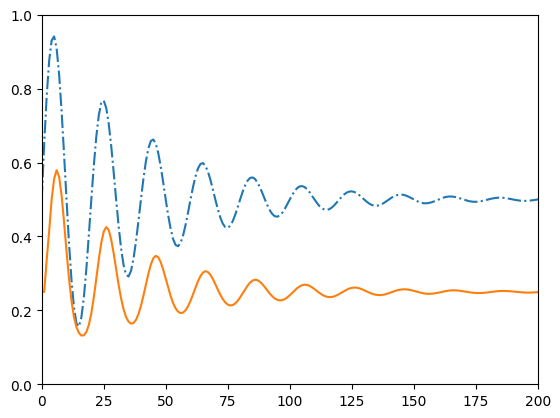

In [ ]:
Combgate = UnitaryGate(Matrix)
Comb = QuantumCircuit(2,1) 
phase0 = np.pi/4.0 # 
fCoef = 1.0
# Comb.rz(phase0, 0)  # z-rotation of qubit 0
# Comb.ry(phase0, 0)  # y-rotation of qubit 0
Comb.append(Combgate, [0, 1])
# Comb.h(1)       
# Comb.cx(0,1)  
timeSpan = 3200
fs = 8000
stateIn = np.zeros(4, dtype = 'complex_') + np.sqrt(0.25) 
sOutIn = Statevector(np.zeros(4, dtype = 'complex_') + np.sqrt(0.25) )
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 1.0; # impulse
input = 0.5+0.5*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
               np.exp(-np.arange(timeSpan)/200*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.0, 1])
plt.xlim([0, 200])
output = np.zeros(timeSpan)
for n in range(timeSpan): 
    output[n] = sOutIn.probabilities()[2] # probability of qubits [1,0]   
    # print("output = ", output[n])
    sIn = Statevector([input[n], np.sqrt((1 - input[n]**2)/3), \
                       np.sqrt((1 - input[n]**2)/3), np.sqrt((1 - input[n]**2)/3)])
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(sOutIn[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(sOutIn[1])**2)/2)
    stateIn[2] = np.sqrt((np.abs(sIn[2])**2 + np.abs(sOutIn[2])**2)/2)
    stateIn[3] = np.sqrt((np.abs(sIn[3])**2 + np.abs(sOutIn[3])**2)/2)
    # print("stateIn = ", stateIn, "sIn = ", sIn.data)
    sOutIn = Statevector(stateIn)
    # print("sOutIn = ", sOutIn.data)
    sOutIn = sOutIn.evolve(Comb)
    # print("sOutIn evolved = ", sOutIn.data)
plt.plot(output) 
if play_sound:   
    sd.play(output-1/np.sqrt(2), fs)

### A maximally diffusive matrix
A $4 \times 4$ matrix that is maximally-diffusive and circulant, it is a Householder reflector, and has Hadamard property (i.e., it is made of $\pm 1$ and has orthogonal rows)

In [ ]:
# A maximally-diffused matrix on two qubits (four classic lines)
Matrix = 0.5 * np.array([[-1.0, 1.0, 1.0, 1.0],
          [1.0, -1.0, 1.0, 1.0],
          [1.0, 1.0, -1.0, 1.0],
          [1.0, 1.0, 1.0, -1.0]])
gate = UnitaryGate(Matrix)

The matrix, as converted into a quantum circuits, evolves the state $\mid 00 \rangle$ into $-\frac{1}{2} \mid 00 \rangle + \frac{1}{2} \mid 01 \rangle + \frac{1}{2} \mid 10 \rangle + \frac{1}{2} \mid 11 \rangle$

In [ ]:
circuit = QuantumCircuit(2,2) 
circuit.append(gate, [0,1])
ket = Statevector(circuit) # evolution of state |00>
print(ket.draw())
circuit.draw()
# circuit.draw(initial_state=False,output='latex').save('unitary.pdf')

Statevector([-0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
            dims=(2, 2))


┌──────────┐
q_0: ┤0         ├
     │  Unitary │
q_1: ┤1         ├
     └──────────┘
c: 2/════════════

How can this circuit be actually expressed in terms of rotations and cnots?
Does it entangle the qubits?

entanglement(ket) =  1.0
entanglement(|++>) =  7.7093068663413005e-31


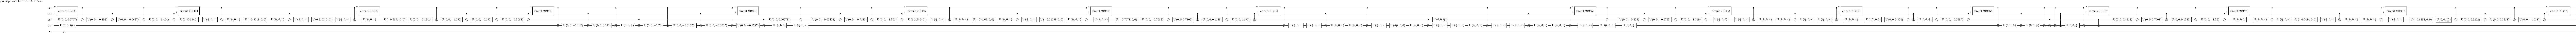

In [ ]:
# unrolling the gate, cnot introduces entanglement
print("entanglement(ket) = ", entanglement_of_formation(ket)) # all entanglement in a minus sign
print("entanglement(|++>) = ", entanglement_of_formation([0.5, 0.5, 0.5, 0.5]))

pm = PassManager(Decompose())
new_circ = pm.run(circuit)
new_circ.draw(initial_state=False,output='latex')#.save('h2.pdf')

Let us run the circuit many times, collect probabilities for each of the four possible outcomes, transform probabilities to amplitudes and assign to state vector. All the amplitudes are set positive, and the measured entanglement is very small.


In [ ]:
backend = Aer.get_backend('aer_simulator')
circuit.measure([0,1],[0,1])
# circuit.measure([1],[1])
shots = 1024
counts = backend.run(circuit,shots=shots).result().get_counts()
probs = {} # empty dictionary
for output in ['00','01','10','11']: # list of possible outputs
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
print('probabilities = ', probs)
amplitudes = np.sqrt(list(probs.values()))
print('amplitudes = ', amplitudes)
stateV = Statevector(amplitudes)
# print(stateV)
print("entanglement = ", entanglement_of_formation(stateV))   
circuit.draw()
if save_figure:
    circuit.draw(initial_state=False,output='latex').save('unitaryMeasure.pdf')

probabilities =  {'00': 0.2548828125, '01': 0.2578125, '10': 0.234375, '11': 0.2529296875}
amplitudes =  [0.5048592006688597 0.5077524002897476 0.4841229182759271
 0.5029211543572213]
entanglement =  0.0010041147825198356


┌──────────┐┌─┐   
q_0: ┤0         ├┤M├───
     │  Unitary │└╥┘┌─┐
q_1: ┤1         ├─╫─┤M├
     └──────────┘ ║ └╥┘
c: 2/═════════════╩══╩═
                  0  1

Second iteration of unitary transformation and measurement. It is like a first iteration in unrolling the loop.

In [ ]:
# second iteration of matrix and measurement (can be iterated many times)
circuit.initialize(amplitudes, circuit.qubits)
circuit.append(gate,circuit.qubits)
circuit.measure([0,1],[0,1])
shots = 1024
counts = backend.run(circuit,shots=shots).result().get_counts()
probs = {} # empty dictionary
for output in ['00','01','10','11']: # list of possible outputs
        if output in counts:
            probs[output] = counts[output]/shots
        else:
            probs[output] = 0
print(probs)
amplitudes = np.sqrt(list(probs.values()))
print(amplitudes)
stateV = Statevector(amplitudes)
# print(stateV)
print("ent(stateV) = ", entanglement_of_formation(stateV)) 
circuit.draw()

{'00': 0.2666015625, '01': 0.224609375, '10': 0.263671875, '11': 0.2451171875}
[0.516334738808072   0.4739297152532219  0.5134898976610932
 0.49509310992983935]
ent(stateV) =  0.002130871639902496


┌──────────┐┌─┐   ┌──────────────────────────────────────────────┐»
q_0: ┤0         ├┤M├───┤0                                             ├»
     │  Unitary │└╥┘┌─┐│  Initialize(0.50486,0.50775,0.48412,0.50292) │»
q_1: ┤1         ├─╫─┤M├┤1                                             ├»
     └──────────┘ ║ └╥┘└──────────────────────────────────────────────┘»
c: 2/═════════════╩══╩═════════════════════════════════════════════════»
                  0  1                                                 »
«     ┌──────────┐┌─┐   
«q_0: ┤0         ├┤M├───
«     │  Unitary │└╥┘┌─┐
«q_1: ┤1         ├─╫─┤M├
«     └──────────┘ ║ └╥┘
«c: 2/═════════════╩══╩═
«                  0  1

Through the iterations of the process the probability amplitudes tend to stay even. 

In [ ]:
print(stateV)
circuit = QuantumCircuit(2,2) 
circuit.append(gate, [0,1])
evolvedState = stateV.evolve(circuit)
print(evolvedState)

Statevector([0.516334738808072  +0.j, 0.4739297152532219 +0.j,
             0.5134898976610932 +0.j, 0.49509310992983935+0.j],
            dims=(2, 2))
Statevector([0.48308899201804123+0.j, 0.5254940155728913 +0.j,
             0.48593383316502003+0.j, 0.5043306208962739 +0.j],
            dims=(2, 2))


<img src="QFDN1.png" width="600">

### Evolution with no measurement
#### Response to impulse, to damped sinusoid, and to vocal trill

*amplitude encoding*: instantaneous input, with scaling and amplitude to stay between 0 and 1, as first amplitude probability. This is essentially quantum probability amplitude modulation (QPAM [[Itaborai and Miranda, 2022](https://link.springer.com/chapter/10.1007/978-3-031-13909-3_10)]). The other probabilities are set equal and power-complementary.

*summation nodes*: these nodes, given $|\psi> = a_0 |00> + b_0 |01> + c_0 |10> + d_0 |11> $ and $|\phi> = a_1 |00> + b_1 |01> + c_1 |10> + d_1 |11> $ compute 

$$
|\psi> + |\phi> = \sqrt{\frac{{|a_0|}^2 + {|a_1|}^2}{2}} |00> + \sqrt{\frac{{|b_0|}^2 + {|b_1|}^2}{2}} |01> + \sqrt{\frac{{|c_0|}^2 + {|c_1|}^2}{2}} |10>  + \sqrt{\frac{{|d_0|}^2 + {|d_1|}^2}{2}} |11>
$$ Later we will replace this with a quantum summation (controlled-not gate).

*amplitudes to probabilities*: The delays are fed with marginal probabilities of qubits, i.e. the probability of a qubit being measured as 0 if nothing is done on the other ($p_{10}$ reads as the probability of qubit 1 to be zero): 
$$
  p_{00} = \operatorname{Pr}(\mathsf{q_0} = 0) 
  = \sum_{b\in\{0,1\}} \operatorname{Pr}\bigl( (\mathsf{q_1},\mathsf{q_0}) 
  = (b,0) \bigr) = Statevector[0]^2 + Statevector[2]^2
$$
$$
  p_{10} = \operatorname{Pr}(\mathsf{q_1} = 0) 
  = \sum_{b\in\{0,1\}} \operatorname{Pr}\bigl( (\mathsf{q_1},\mathsf{q_0}) 
  = (0,b) \bigr) = Statevector[0]^2 + Statevector[1]^2
$$
This is equivalent, for each qubit, to tracing out the other qubit from the density matrix and taking the top-left component: 
```
pdm = partial_trace(Statevector(ss), [1])
p00 = np.diagonal(pdm)[0]
```

Later, we will propagate with delay lines the (four) probability amplitudes instead of the (two) marginal probabilities of qubits.

*probabilities to amplitudes*: The underdetermined system
$$
\begin{aligned}
    {a}^2 + {c}^2 = p_{00} \\
    {a}^2 + {b}^2 = p_{10}, 
  \end{aligned}
$$
constrained by the sum of squares of amplitudes being 1,
is solved by
$$
\begin{aligned}
    a^2 = min(p_{00}, p_{10}) \\
    b^2 = p_{10} - a^2 \\
    c^2 = p_{00} - a^2 \\
    d^2 = 1 + a^2 - p_{10} - p_{00}
  \end{aligned}
$$

*output*: probability of first (delayed) qubit being 0 when measured (doing nothing to the other)

*additional components*: rotation of qubit 0 around z (moves the transition of regimes); swapping qubits (changes waveform); probability feedback coefficient on qubit 0 (changes the amplitude of regime). Rotation around y makes the sound attenuate

*initialization of delay lines*: the delay lines are initially filled with equal probabilities. A zero input (actually offset to 0.5) should correspond to constant output. Positive (1.0) as well as negative (0.0) impulses give oscillation.

*impulse response*: it is a combed comb, where the smallest delay gives the larger frequency periodicity

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2409180646.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2409180646.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[1] = np.sqrt(delay[1].get() - aq)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2409180646.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[2] = np.sqrt(delay[0].get() - aq)


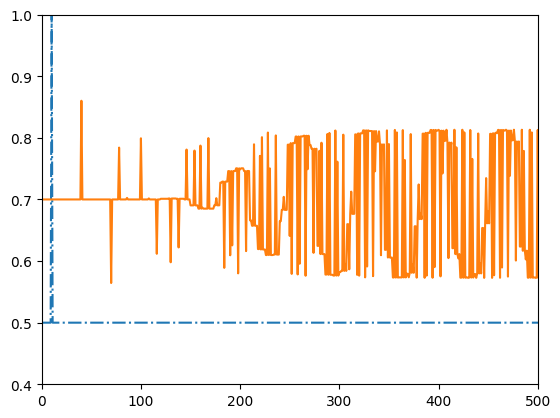

In [ ]:
# Quantum Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(2,2) 
phase0 = np.pi/4.0 # 
fCoef = 0.99
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
m1 = 29
m2 = 37
initDelay = 0.5
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m1, initDelay), CircularBuffer(m2, initDelay)]
stateIn = np.zeros(4) + 0.5
stateOut = np.zeros(4) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 1.0; # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/200*2*np.pi*10)* \
#                 np.exp(-np.arange(timeSpan)/200*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.4, 1])
plt.xlim([0, 500])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = min(delay[0].get(), delay[1].get())  # delays output probabilities
    stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
    stateOut[1] = np.sqrt(delay[1].get() - aq) 
    stateOut[2] = np.sqrt(delay[0].get() - aq) 
    stateOut[3] = np.sqrt(1 - np.abs(stateOut[0])**2 - np.abs(stateOut[1])**2 - np.abs(stateOut[2])**2)
    # input of delays are marginal probabilities 
    # delay[0].put(np.abs(stateIn[0])**2 + np.abs(stateIn[2])**2) 
    # delay[1].put(np.abs(stateIn[0])**2 + np.abs(stateIn[1])**2)
    delay[0].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [1]))[0]))
    delay[1].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [0]))[0]))
    sOut = Statevector(stateOut)
    output[n] = np.sqrt(sOut.probabilities([0])[0])  # sqrt of probability of qubit 0 being up 
    sOut = sOut.evolve(FDN)
    stateOut = sOut.data
    sIn = Statevector([input[n], np.sqrt((1 - input[n]**2)/3), \
                       np.sqrt((1 - input[n]**2)/3), np.sqrt((1 - input[n]**2)/3)])
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(stateOut[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(stateOut[1])**2)/2)
    stateIn[2] = np.sqrt((np.abs(sIn[2])**2 + np.abs(stateOut[2])**2)/2)
    stateIn[3] = np.sqrt((np.abs(sIn[3])**2 + np.abs(stateOut[3])**2)/2)
plt.plot(output)   
# plt.grid()
if save_figure:
    plt.savefig('qfdn2qubitsImpulse.pdf')
if play_sound:
    sd.play(output-1/np.sqrt(2), fs)
if save_sound:
    UF.wavwrite(output-1/np.sqrt(2), fs, "qfdn2qubitsImpulse.wav")

we can compare with a classic 2x2 FDN

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/1229919130.py:24: ComplexWarning: Casting complex values to real discards the imaginary part
  output[n] = aq[0]
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/1229919130.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  stateIn[0] = input[n] + stateOut[0]
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/1229919130.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  stateIn[1] = stateOut[1]


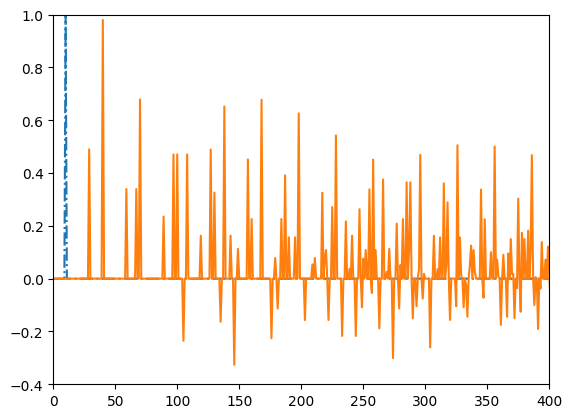

In [ ]:
# Feedback Delay Network
Matrix = np.array([[1, 1],
          [1, -1]]/np.sqrt(2))
fCoef = 0.98
m1 = 29
m2 = 37
initDelay = 0.0
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m1, initDelay), CircularBuffer(m2, initDelay)]
stateIn = np.zeros(2) + 0.5
stateOut = np.zeros(2) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan); input[10] = 1.0; # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#                 np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([-0.4, 1])
plt.xlim([0, 400])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = np.array([delay[0].get(), delay[1].get()]) * fCoef # delays output 
    output[n] = aq[0]
    stateOut = Matrix.dot(aq) 
    delay[0].put(stateIn[0])
    delay[1].put(stateIn[1])
    stateIn[0] = input[n] + stateOut[0]
    stateIn[1] = stateOut[1]
plt.plot(output)
if save_figure:
    plt.savefig('fdn2x2Impulse.pdf')
if play_sound:
    sd.play(output, fs)
if save_sound:
    UF.wavwrite(output, fs, "fdn2x2Impulse.wav")    

### Evolution with measurement

A measurement of one qubit is inserted after evolution of state (i.e., after matrix multiplication), just to observe how it affects the resulting sound. The result is an 
irregularly-comb-filtered noise

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/142473457.py:33: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[0] = np.sqrt(aq) * fCoef           # compute amplitudes (try with changing signs)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/142473457.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[1] = np.sqrt(delay[1].get() - aq)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/142473457.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[2] = np.sqrt(delay[0].get() - aq)


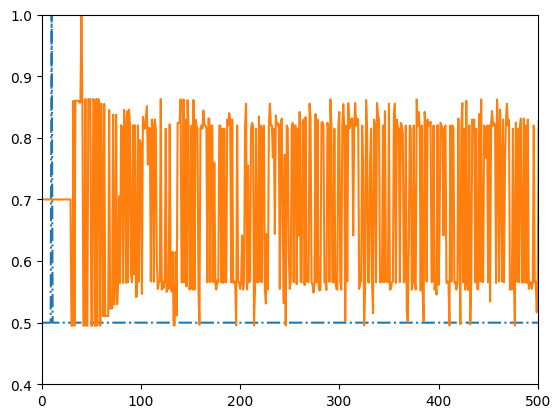

In [ ]:
# Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(2,2) 
phase0 = np.pi/4.0 # 
fCoef = 0.99
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
m1 = 29
m2 = 37
initDelay = 0.5
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m1, initDelay), CircularBuffer(m2, initDelay)]
stateIn = np.zeros(4) + 0.5
stateOut = np.zeros(4) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 1.0 # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#                 np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.4, 1])
plt.xlim([0, 500])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = min(delay[0].get(), delay[1].get())    # delays output probabilities
    stateOut[0] = np.sqrt(aq) * fCoef           # compute amplitudes (try with changing signs)
    stateOut[1] = np.sqrt(delay[1].get() - aq) 
    stateOut[2] = np.sqrt(delay[0].get() - aq) 
    stateOut[3] = np.sqrt(1 - np.abs(stateOut[0])**2 - np.abs(stateOut[1])**2 - np.abs(stateOut[2])**2)
    # input of delays are marginal probabilities 
    delay[0].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [1]))[0]))
    delay[1].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [0]))[0]))
    sOut = Statevector(stateOut)
    output[n] = np.sqrt(sOut.probabilities([0])[0]) # sqrt of probability of qubit 0 being up    
    sOut = sOut.evolve(FDN)
    (outcome, sOut) = sOut.measure([1]) # insert the measurement of one qubit after state evolution
    stateOut = sOut.data
    sIn = Statevector([input[n], np.sqrt((1 - input[n]**2)/3), \
                       np.sqrt((1 - input[n]**2)/3), np.sqrt((1 - input[n]**2)/3)])
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(stateOut[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(stateOut[1])**2)/2)
    stateIn[2] = np.sqrt((np.abs(sIn[2])**2 + np.abs(stateOut[2])**2)/2)
    stateIn[3] = np.sqrt((np.abs(sIn[3])**2 + np.abs(stateOut[3])**2)/2)
plt.plot(output)
if save_figure:    
    plt.savefig('qfdn2qubitsImpulseMeasure.pdf')
if play_sound:
    sd.play(output-1/np.sqrt(2), fs)
if save_sound:
    UF.wavwrite(output-1/np.sqrt(2), fs, "qfdn2qubitsImpulseMeasure.wav")

### Evolution with sampling of measurements

State after matrix evolution is repeatedly measured and frequencies are transformed to probabilities, and to amplitudes.  The number of samples (```ns```) controls how noisy the output is. The lower the number of samples, the higher the noisiness. With a very small number of samples (e.g., 16) the quantization noise is evident.

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2174665328.py:37: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2174665328.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[1] = np.sqrt(delay[1].get() - aq)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2174665328.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[2] = np.sqrt(delay[0].get() - aq)


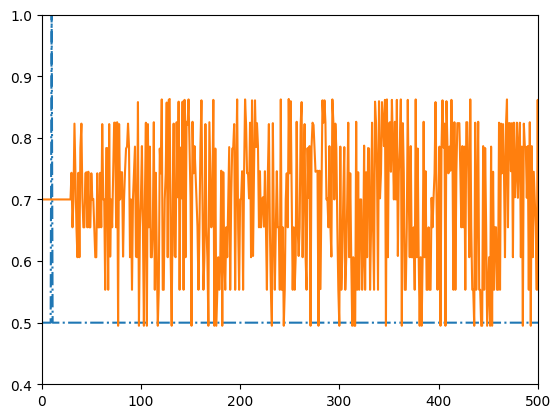

In [ ]:
# Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(2,2) 
phase0 = np.pi/4.0 # 
fCoef = 0.99
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
m1 = 29
m2 = 37
initDelay = 0.5
timeSpan = 3200
fs = 8000
ns = 8 # number of samples; 
         # you need about 100000 samples for three precise digits in probabilities
         # and still this is not enough to reproduce the probabilities
probs = np.zeros(4)
delay = [CircularBuffer(m1, initDelay), CircularBuffer(m2, initDelay)]
stateIn = np.zeros(4) + 0.5
stateOut = np.zeros(4) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 1.0 # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#               np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input, '-.')
plt.ylim([0.4, 1])
plt.xlim([0, 500])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = min(delay[0].get(), delay[1].get())  # delays output probabilities
    stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
    stateOut[1] = np.sqrt(delay[1].get() - aq) 
    stateOut[2] = np.sqrt(delay[0].get() - aq) 
    stateOut[3] = np.sqrt(1 - np.abs(stateOut[0])**2 - np.abs(stateOut[1])**2 - np.abs(stateOut[2])**2)
    # input of delays are marginal probabilities 
    delay[0].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [1]))[0]))
    delay[1].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [0]))[0]))
    sOut = Statevector(stateOut)
    output[n] = np.sqrt(sOut.probabilities([0])[0]) # sqrt of probability of qubit 0 being up    sOut = sOut.evolve(FDN)
    sOut = sOut.evolve(FDN)
    counts = sOut.sample_counts(ns)
    labels = ['00','01','10','11']
    for oo in labels: # list of possible outputs
        if oo in counts:
            probs[labels.index(oo)] = counts[oo]/ns
        else:
            probs[labels.index(oo)] = 0   
    # print("exact = ", sOut.data)
    sOut = Statevector(np.sqrt(probs))
    # print("sampled = ", sOut.data)
    stateOut = sOut.data
    sIn = Statevector([input[n], np.sqrt((1 - input[n]**2)/3), \
                       np.sqrt((1 - input[n]**2)/3), np.sqrt((1 - input[n]**2)/3)])
    stateIn[0] = np.sqrt((np.abs(sIn[0])**2 + np.abs(stateOut[0])**2)/2)
    stateIn[1] = np.sqrt((np.abs(sIn[1])**2 + np.abs(stateOut[1])**2)/2)
    stateIn[2] = np.sqrt((np.abs(sIn[2])**2 + np.abs(stateOut[2])**2)/2)
    stateIn[3] = np.sqrt((np.abs(sIn[3])**2 + np.abs(stateOut[3])**2)/2)
plt.plot(output)
if save_figure:    
    plt.savefig('qfdn2qubitsImpulseSamplingMeasure.pdf')
if play_sound:
    sd.play(output-1/np.sqrt(2), fs)
if save_sound:
    UF.wavwrite(output-1/np.sqrt(2), fs, "qfdn2qubitsImpulseSamplingMeasure.wav")

    

### CNOTing the input
Instead of a power-preserving addition of amplitudes at the summation nodes of the FDN general scheme, we can perform a quantum addition by means of a controlled-not gate. One extra qubit ($q_2$) is introduced to encode the input, that is c-noted with qubit $q_0$. If we also consider the possibility of rotations around the Z and Y axes, as well as a qubit swap, the overall unitary transformation reads as follows.

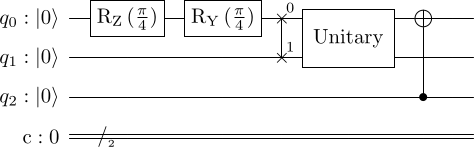

In [ ]:
# Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(3,2) 
phase0 = np.pi/4.0 # 
FDN.rz(phase0, 0)  # z-rotation of qubit 0
FDN.ry(phase0, 0)  # y-rotation of qubit 0
FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
FDN.cx(2,0)
FDN.draw(initial_state=True,output='latex')# .save('circuit16x16.pdf')


This feedback unitary transformation is used as follows (with no explicit measurement and no sampling). The result should be compared with that of [Evolution with no measurement](#Evolution-with-no-measurement). Here, with ```fCoef``` sufficiently small, the impulse response is effectively damped and similar to that of an actual reverb. For example, try with ```fCoef = 0.95```. However, the behavior is non-linear and with a non-impulsive input the behavior is more articulate, displaying localized transients. With a vocal trill input, it tends to display isolated transients and preserve the input.

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2336955564.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2336955564.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[1] = np.sqrt(delay[1].get() - aq)
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2336955564.py:36: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[2] = np.sqrt(delay[0].get() - aq)


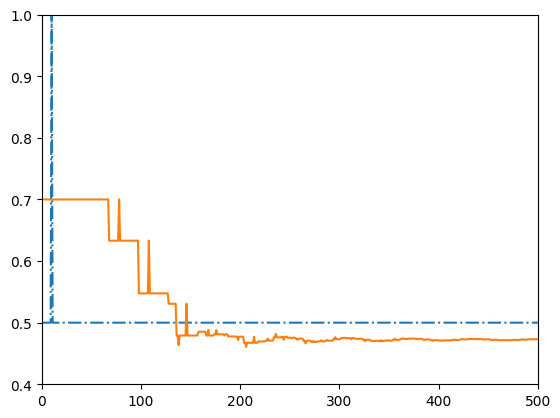

In [ ]:
# Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(3,2) 
phase0 = np.pi/4.0 # 
fCoef = 0.99
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
FDN.cx(2,0)
m1 = 29
m2 = 37
initDelay = 0.5
timeSpan = 3200
fs = 8000
delay = [CircularBuffer(m1, initDelay), CircularBuffer(m2, initDelay)]
stateIn = np.zeros(4) + 0.5
stateOut = np.zeros(4) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[10] = 1.0 # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#                np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input,'-.')
plt.ylim([0.4, 1])
plt.xlim([0, 500])
output = np.zeros(timeSpan)
for n in range(timeSpan):
    aq = min(delay[0].get(), delay[1].get())  # delays output probabilities
    stateOut[0] = np.sqrt(aq) * fCoef         # compute amplitudes (try with changing signs)
    stateOut[1] = np.sqrt(delay[1].get() - aq)  
    stateOut[2] = np.sqrt(delay[0].get() - aq) 
    stateOut[3] = np.sqrt(1 - np.abs(stateOut[0])**2 - np.abs(stateOut[1])**2 - np.abs(stateOut[2])**2)
    # input of delays are marginal probabilities 
    delay[0].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [1]))[0]))
    delay[1].put(np.abs(np.diagonal(partial_trace(Statevector(stateIn), [0]))[0]))
    sOut = Statevector(stateOut)    
    output[n] = np.sqrt(sOut.probabilities([0])[0]) # sqrt of probability of qubit 0 being up    
    sIn = Statevector([np.sqrt((1 - input[n]**2)), input[n]])
    sOutIn = sOut.tensor(sIn) # extend the state to include the qubit encoding the input
    sOutIn = sOutIn.evolve(FDN)
    partial_density_matrix = partial_trace(sOutIn, [2]) # trace out the extra qubit
    stateIn = np.diagonal(partial_density_matrix)
    stateIn = stateIn / np.sqrt(np.sum(np.square(stateIn)))
plt.plot(output)
if play_sound:    
    sd.play(output-0.5, fs)

### Delaying the probability amplitudes
4 delay lines instead of 2. C-noted input.

/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2988453887.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[0] = delay[0].get()*fCoef/ssq
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2988453887.py:41: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[1] = delay[1].get()/ssq
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2988453887.py:42: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[2] = delay[2].get()/ssq
/var/folders/j4/0lv7gs9s385byhj07wh6tch40000gp/T/ipykernel_63135/2988453887.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  stateOut[3] = delay[3].get()/ssq


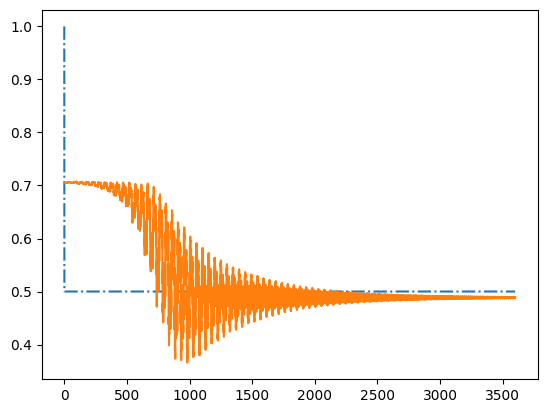

In [ ]:
# Feedback Delay Network
Matrix = [[-.5, .5, .5, .5],
          [.5, -.5, .5, .5],
          [.5, .5, -.5, .5],
          [.5, .5, .5, -.5]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(3,2) 
phase0 = np.pi/4.0 # 
fCoef = 0.99
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0,1])
FDN.cx(2,0)
m0 = 23
m1 = 29
m2 = 51
m3 = 73
# m0 = 291
# m1 = 271
# m2 = 529
# m3 = 777
initDelays = 0.5
timeSpan = 3600
fs = 8000
delay = [CircularBuffer(m0, initDelays), CircularBuffer(m1, initDelays), \
         CircularBuffer(m2, initDelays), CircularBuffer(m3, initDelays)]
stateIn = np.zeros(4) + 0.5
stateOut = np.zeros(4) + 0.5
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[0] = 1.0 # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#        np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input,'-.')
output = np.zeros(timeSpan)
for n in range(timeSpan):
    ssq = np.sqrt(np.abs(delay[0].get()*fCoef)**2 + np.abs(delay[1].get())**2 + \
                  np.abs(delay[2].get())**2 + np.abs(delay[3].get())**2)
    stateOut[0] = delay[0].get()*fCoef/ssq        
    stateOut[1] = delay[1].get()/ssq        
    stateOut[2] = delay[2].get()/ssq        
    stateOut[3] = delay[3].get()/ssq   
    delay[0].put(stateIn[0])
    delay[1].put(stateIn[1])
    delay[2].put(stateIn[2])
    delay[3].put(stateIn[3])
    sOut = Statevector(stateOut)    
    output[n] = np.sqrt(sOut.probabilities([0])[0]) # probability of qubit 0 being up    
    sIn = Statevector([np.sqrt((1 - input[n]**2)), input[n]])
    sOutIn = sOut.tensor(sIn) # extend the state to include the qubit encoding the input
    sOutIn = sOutIn.evolve(FDN)
    partial_density_matrix = partial_trace(sOutIn, [2]) # trace out the extra qubit
    stateIn = np.diagonal(partial_density_matrix)
    stateIn = stateIn / np.sqrt(np.sum(np.square(stateIn)))
plt.plot(output)
if play_sound:    
    sd.play(output-0.5, fs)

### The FDN in state space form
If we start from a quantum feedback delay network on $n$ qubits where the $2^n$ probability amplitudes are propagated through delay lines, this can be transformed in state-space form and represented with a single large unitary matrix. If $n = 2$ we have a $4$ delay lines for the probability amplitudes. If these lines have lengths $\{2, 2, 5, 7\}$, the state space will have size $16$ and the overall unitary matrix will be $16 \times 16$. This means that the quantum evolution operates on $4$ qubits. Longer delays would require more qubits. In the $16 \times 16$ example below the realization with elementary rotations and c-not gives the count: ```{'u': 194, 'cx': 99}```

In [ ]:
# Feedback Delay Network
Matrix = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -.5, .5, .5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, -.5, .5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, .5, -.5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, .5, .5, -.5],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
Matrix = np.array(Matrix, dtype = 'complex_')
FDNgate = UnitaryGate(Matrix)
circuit = QuantumCircuit(4,2) 
circuit.append(FDNgate, [0, 1, 2, 3])

# pass_ = Unroller(['p','u','cx'])
# pm = PassManager(pass_)
pm = PassManager(Decompose())
new_circ = pm.run(circuit)
new_circ.draw(initial_state=True,output='mpl',filename='circuit16x16.pdf')
print(dict(new_circ.count_ops()))

{'u': 98, 'cx': 67, 'circuit-198418': 1, 'circuit-198421': 1, 'circuit-198424': 1, 'circuit-198427': 1, 'circuit-198430': 1, 'circuit-198433': 1, 'circuit-198436': 1, 'circuit-198439': 1, 'circuit-198442': 1, 'circuit-198445': 1, 'circuit-198448': 1, 'circuit-198451': 1, 'circuit-198454': 1, 'circuit-198457': 1, 'circuit-198460': 1, 'circuit-198463': 1}


### State-space FDN with summation input nodes¶

### State-space FDN with c-noted input
One extra qubit ($q_4$) is introduced to encode the input, and it is c-noted with qubit $q_0$

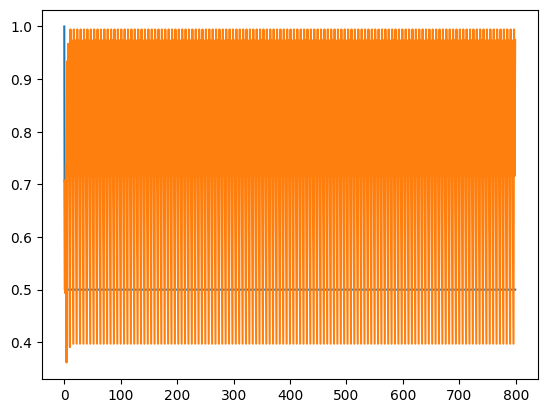

In [ ]:
# Feedback Delay Network
Matrix = [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -.5, .5, .5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, -.5, .5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, .5, -.5, .5],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, .5, .5, .5, -.5],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]
FDNgate = UnitaryGate(Matrix)
FDN = QuantumCircuit(5,2) 
phase0 = np.pi/4.0 # 
# FDN.rz(phase0, 0)  # z-rotation of qubit 0
# FDN.ry(phase0, 0)  # y-rotation of qubit 0
# FDN.swap(0,1)    # swapping qubits
FDN.append(FDNgate, [0, 1, 2, 3])
FDN.cx(4,0)
timeSpan = 800
fs = 8000
stateOut = np.zeros(16) + 1/4 # state is initialized to maximal superposition
# stateOut = np.zeros(16); stateOut[0] = 1 # state is initialized to |0000>
inputFile = './track82ex02.wav'
input = np.zeros(timeSpan) + 0.5; input[0] = 1.0 # impulse
# input = 0.5+0.5*np.sin(np.arange(timeSpan)/timeSpan*2*np.pi*10)* \
#             np.exp(-np.arange(timeSpan)/timeSpan*5) # damped sine
# (fs, x) = UF.wavread(inputFile); timeSpan = x.size; input = x/2 + 0.5; 
plt.plot(input)
output = np.zeros(timeSpan)
for n in range(timeSpan):
    sOut = Statevector(stateOut)
    output[n] = np.sqrt(sOut.probabilities([0])[0]) # sqrt of probability of qubit 0 being up
    sIn = Statevector([np.sqrt((1 - input[n]**2)), input[n]])
    sOutIn = sOut.tensor(sIn) # cnoting the input with the feedback out
    sOutIn = sOutIn.evolve(FDN)
    partial_density_matrix = partial_trace(sOutIn, [4]) # trace out qubit 4
    stateOut = np.diagonal(partial_density_matrix)
    stateOut = stateOut / np.sqrt(np.sum(np.square(stateOut)))
plt.plot(output)
if play_sound:    
    sd.play(output-0.5, fs)
if save_sound:
    UF.wavwrite(output-0.5, fs, "brinbrin.wav")

In [ ]:
proba = [0.3, 0.2, 0.1, 0.4]
s1 = Statevector(np.sqrt(proba))
nss = 100000
counts = s1.sample_counts(nss)
for oo in labels: # list of possible outputs
    if oo in counts:
        probs[labels.index(oo)] = counts[oo]/nss
    else:
        probs[labels.index(oo)] = 0   
print(probs)
print(proba)
print(np.abs(proba - probs))

[0.29992 0.1993  0.10051 0.40027]
[0.3, 0.2, 0.1, 0.4]
[7.9999999999968985e-05 7.0000000000000617e-04 5.0999999999999657e-04
 2.6999999999999247e-04]
